In [101]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

import sys
if '../' not in sys.path:
    sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [104]:
from matplotlib import pyplot as plt
%matplotlib inline

import networkx as nx
import numpy as np
import argparse
import joblib
import os

from analysis import Evaluation
from dynamics import SIRDynamicalSystem
import helpers
from graph_generation import make_ebola_network

Construct the adjacency  matrix of the propagation network

In [109]:
# net = nx.Graph()
# net.add_edges_from([
#     (0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,8), (8,9)
# ])
# A = nx.adjacency_matrix(net).toarray().astype(float)

# n_nodes = net.number_of_nodes()
# n_edges = net.number_of_edges()
# print(f"Network: {n_nodes:d} nodes, {n_edges:d} edges")

# X_init = np.zeros(n_nodes)
# X_init[0] = 1

In [127]:
net = make_ebola_network(n_nodes=500)
A = nx.adjacency_matrix(net).toarray().astype(float)

n_nodes = net.number_of_nodes()
n_edges = net.number_of_edges()
print(f"Network: {n_nodes:d} nodes, {n_edges:d} edges")

n_seeds = 50
X_init = np.hstack(((np.ones(infected), np.zeros(n_nodes - n_seeds))))
X_init = np.random.permutation(X_init)

print(f"Choose a random set of {X_init.sum():.0f} initial infected seeds")
print()

Network: 500 nodes, 14101 edges
Choose a random set of 50 initial infected seeds



In [128]:
sim_dict = {
    'total_time': 1000.00,
    'trials_per_setting': 5
}
param_dict = {
    'beta':  1.0/15.3,
    'gamma': 1.0/15.3,
    'delta': 1.0/11.4,
    'rho':   1.0/6.0,
    'eta':   1.0
}
cost_dict = {
    'Qlam': 1.0,
    'Qx': 1.0
}
policy_list = [
    'SOC',
]
baselines_dict = {
    'TR': 0.003,
    'MN': 0.0007,
    'LN': 0.0008,
    'LRSR': 22.807,
    'MCM': 22.807,
    'FL_info': {'N': None, 'max_u': None},
}

In [129]:
param_dict

{'beta': 0.06535947712418301,
 'gamma': 0.06535947712418301,
 'delta': 0.08771929824561403,
 'rho': 0.16666666666666666,
 'eta': 1.0}

In [130]:
system = SIRDynamicalSystem(X_init, A, param_dict, cost_dict, debug=False, verbose=True, notebook=True)
data = system.simulate_policy('SOC', baselines_dict, sim_dict, plot=False)

time   0.22/1000.00 | S:  409, I:  90, R: 1, H: 6, lY: 259.48, lW: 8.89, lN: 14.44 | 3.67 iter/s             

KeyboardInterrupt: 

In [81]:
X = np.array([system.X[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
Y = np.array([system.Y[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
W = np.array([system.W[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
H = np.array([system.H[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])

In [82]:
X.sum(), H.sum()

(3.0, 3.0)

In [83]:
Y.sum(), Y.max()

(60.0, 1.0)

In [84]:
W.sum(), W.max()

(57.0, 1.0)

In [85]:
hf = helpers.HelperFunc()

tspace = np.arange(0.0, 25.0, 0.01)

# Extract the values of the stochastic processes at all times
y_values = np.zeros(len(tspace))
w_values = np.zeros(len(tspace))
for k, t in enumerate(tspace):
    y_values[k] = hf.sps_values(system.Y, t, summed=True)
    w_values[k] = hf.sps_values(system.W, t, summed=True)

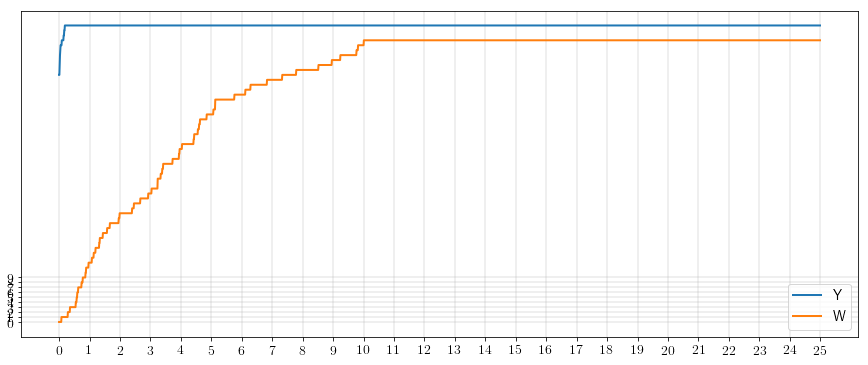

In [86]:
plt.figure(figsize=(15,6))
plt.grid()
plt.plot(tspace, y_values, label='Y')
plt.plot(tspace, w_values, label='W')
plt.xticks(np.arange(0,tspace[-1]+1.0,1.0))
plt.yticks(range(10))
plt.legend();